### 이미 아는 부분은 빠르게 넘어가자

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import string
import warnings
import missingno
warnings.filterwarnings('ignore')

In [20]:
df_train = pd.read_csv('../Study_For_MachineLearning/Titanic/train.csv')
df_test = pd.read_csv('../Study_For_MachineLearning/Titanic/test.csv')
df_all = pd.concat((df_train, df_test)).reset_index(drop=True)

<AxesSubplot: >

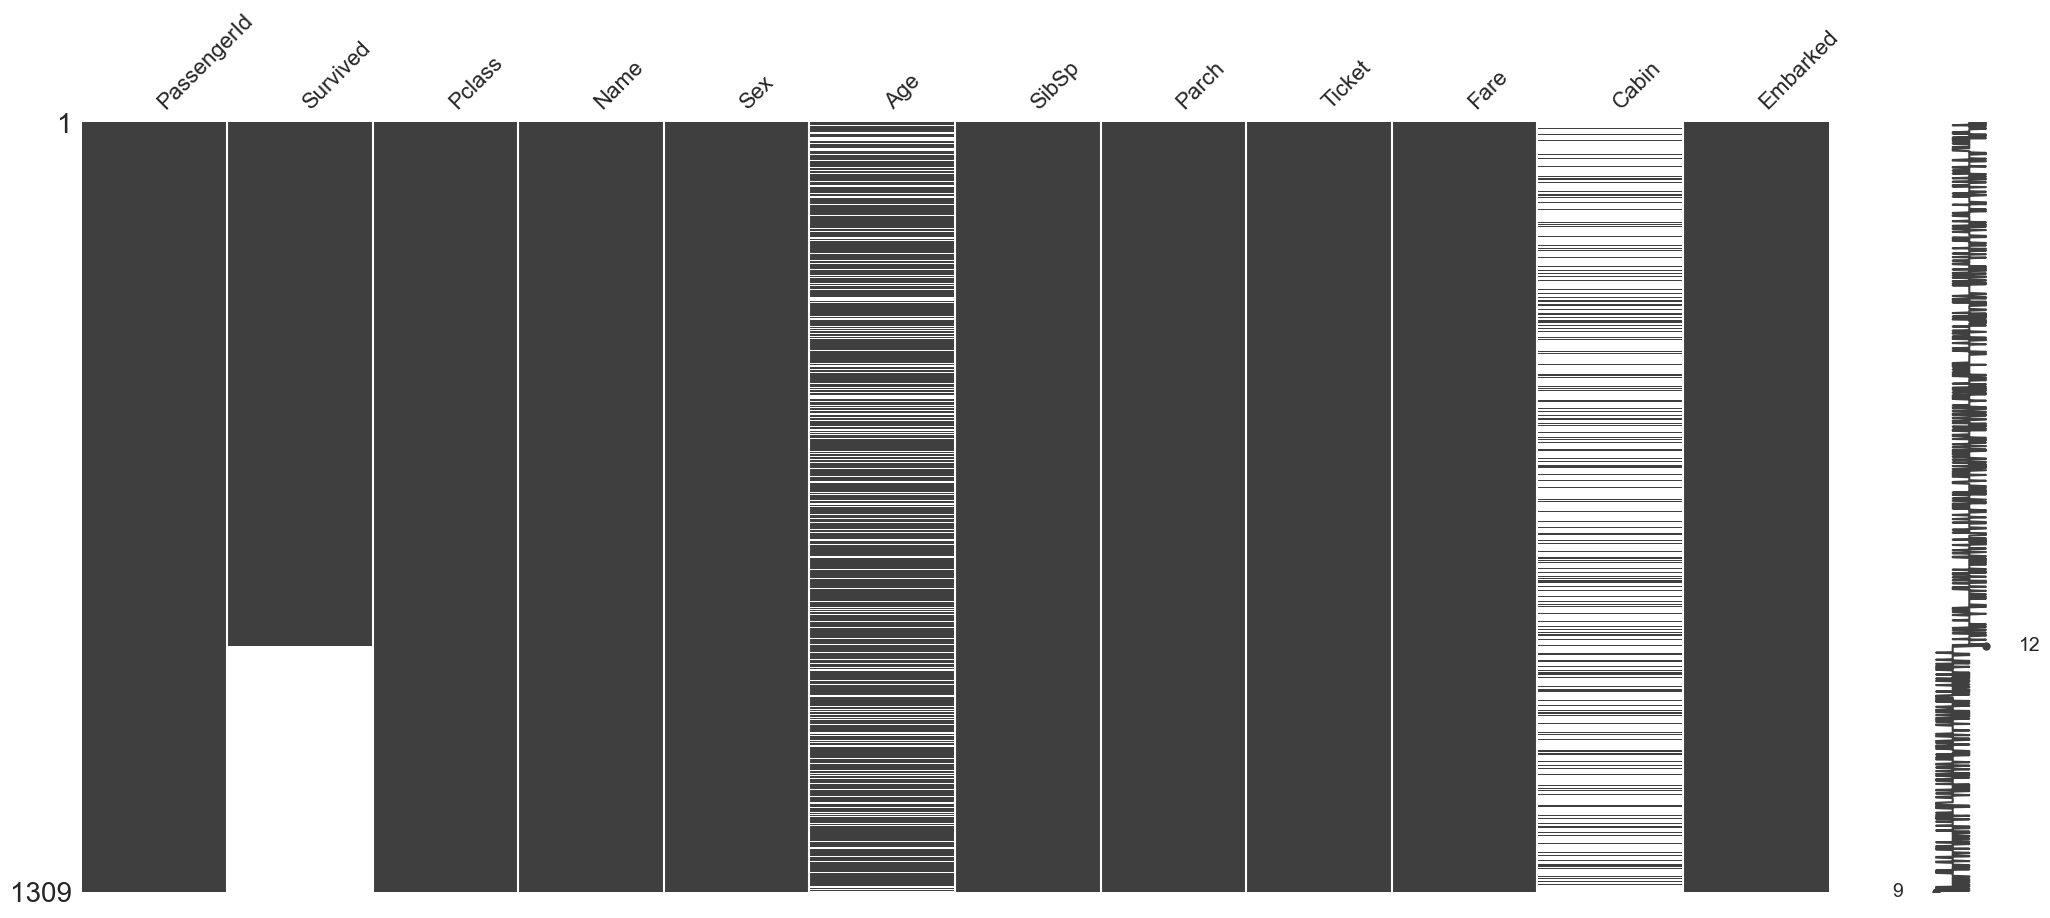

In [21]:
missingno.matrix(df_all)

### 1. Name (Name 부분 수정)

In [22]:
df_all['Name'].unique()

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina', ..., 'Saether, Mr. Simon Sivertsen',
       'Ware, Mr. Frederick', 'Peter, Master. Michael J'], dtype=object)

In [23]:
df_all['Title'] = df_all.Name.str.extract('([A-Za-z]+)\. ')

In [24]:
df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'Countess', 'Dona'], 'Mz')
df_all['Title'] = df_all['Title'].replace(['Don', 'Dr','Rev', 'Col', 'Major', 'Capt', 'Sir', 'Jonkheer'], 'Honor')
df_all['Title'].value_counts()

Mr        757
Mz        465
Master     61
Honor      26
Name: Title, dtype: int64

### 2. Age: 결측치는 중위값으로 대체

In [25]:
df_all['Age'] = df_all.groupby(['Title', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

### 3. Embarked 결측치는 무엇으로 대체할 것인가?

In [26]:
df_all[df_all['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Mz
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mz


- 결측치 2개 모두 Ticket: 113572
- Cabin의 이름은 B28

In [27]:
df_all['Ticket']

0                A/5 21171
1                 PC 17599
2         STON/O2. 3101282
3                   113803
4                   373450
               ...        
1304             A.5. 3236
1305              PC 17758
1306    SOTON/O.Q. 3101262
1307                359309
1308                  2668
Name: Ticket, Length: 1309, dtype: object

In [28]:
df_all[df_all['Cabin'].str.startswith('B2', na=False)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.00,B28,NaN,Mz
540,541,1.0,1,"Crosby, Miss. Harriet R",female,36.0,0,2,WE/P 5735,71.00,B22,S,Mz
690,691,1.0,1,"Dick, Mr. Albert Adrian",male,31.0,1,0,17474,57.00,B20,S,Mr
745,746,0.0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.00,B22,S,Honor
781,782,1.0,1,"Dick, Mrs. Albert Adrian (Vera Gillespie)",female,17.0,1,0,17474,57.00,B20,S,Mz
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.00,B28,NaN,Mz
1196,1197,NaN,1,"Crosby, Mrs. Edward Gifford (Catherine Elizabe...",female,64.0,1,1,112901,26.55,B26,S,Mz
1281,1282,NaN,1,"Payne, Mr. Vivian Ponsonby",male,23.0,0,0,12749,93.50,B24,S,Mr


객실이름(Cabin)이 B2인 사람들은 Embarked가 S이므로, S로 대체하면 될 것 같다.

In [29]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

### 4. Fare: null값에 대해서 중위요금으로 대체

In [31]:
df_all[df_all['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr


- Null값의 경우, Pclass: 3, Parch: 0, Sibsp: 0, Embarked: S 이므로 이 값들을 모두 공통으로 가지는 사람들의 중위값으로 대체.

In [33]:
df_all[(df_all['Pclass'] == 3) & (df_all['Parch'] == 0) & (df_all['SibSp'] == 0)
& (df_all['Embarked'] == 'S')]['Fare'].median()

7.8958

In [34]:
median_fare = df_all[(df_all['Pclass'] == 3) & (df_all['Parch'] == 0) & (df_all['SibSp'] == 0) & (df_all['Embarked'] == 'S')]['Fare'].median()

df_all['Fare'] = df_all['Fare'].fillna(median_fare)

### 5. Cabin

In [36]:
df_all['Cabin'].str[0].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [38]:
df_all['Cabin'] = df_all['Cabin'].str[0]
df_all['Cabin'] = df_all['Cabin'].fillna('X')
df_all.loc[(df_all['Cabin'] == 'T'), 'Cabin'] = 'A'

In [39]:
df_all['Cabin'].value_counts()

X    1014
C      94
B      65
D      46
E      41
A      23
F      21
G       5
Name: Cabin, dtype: int64

<AxesSubplot: >

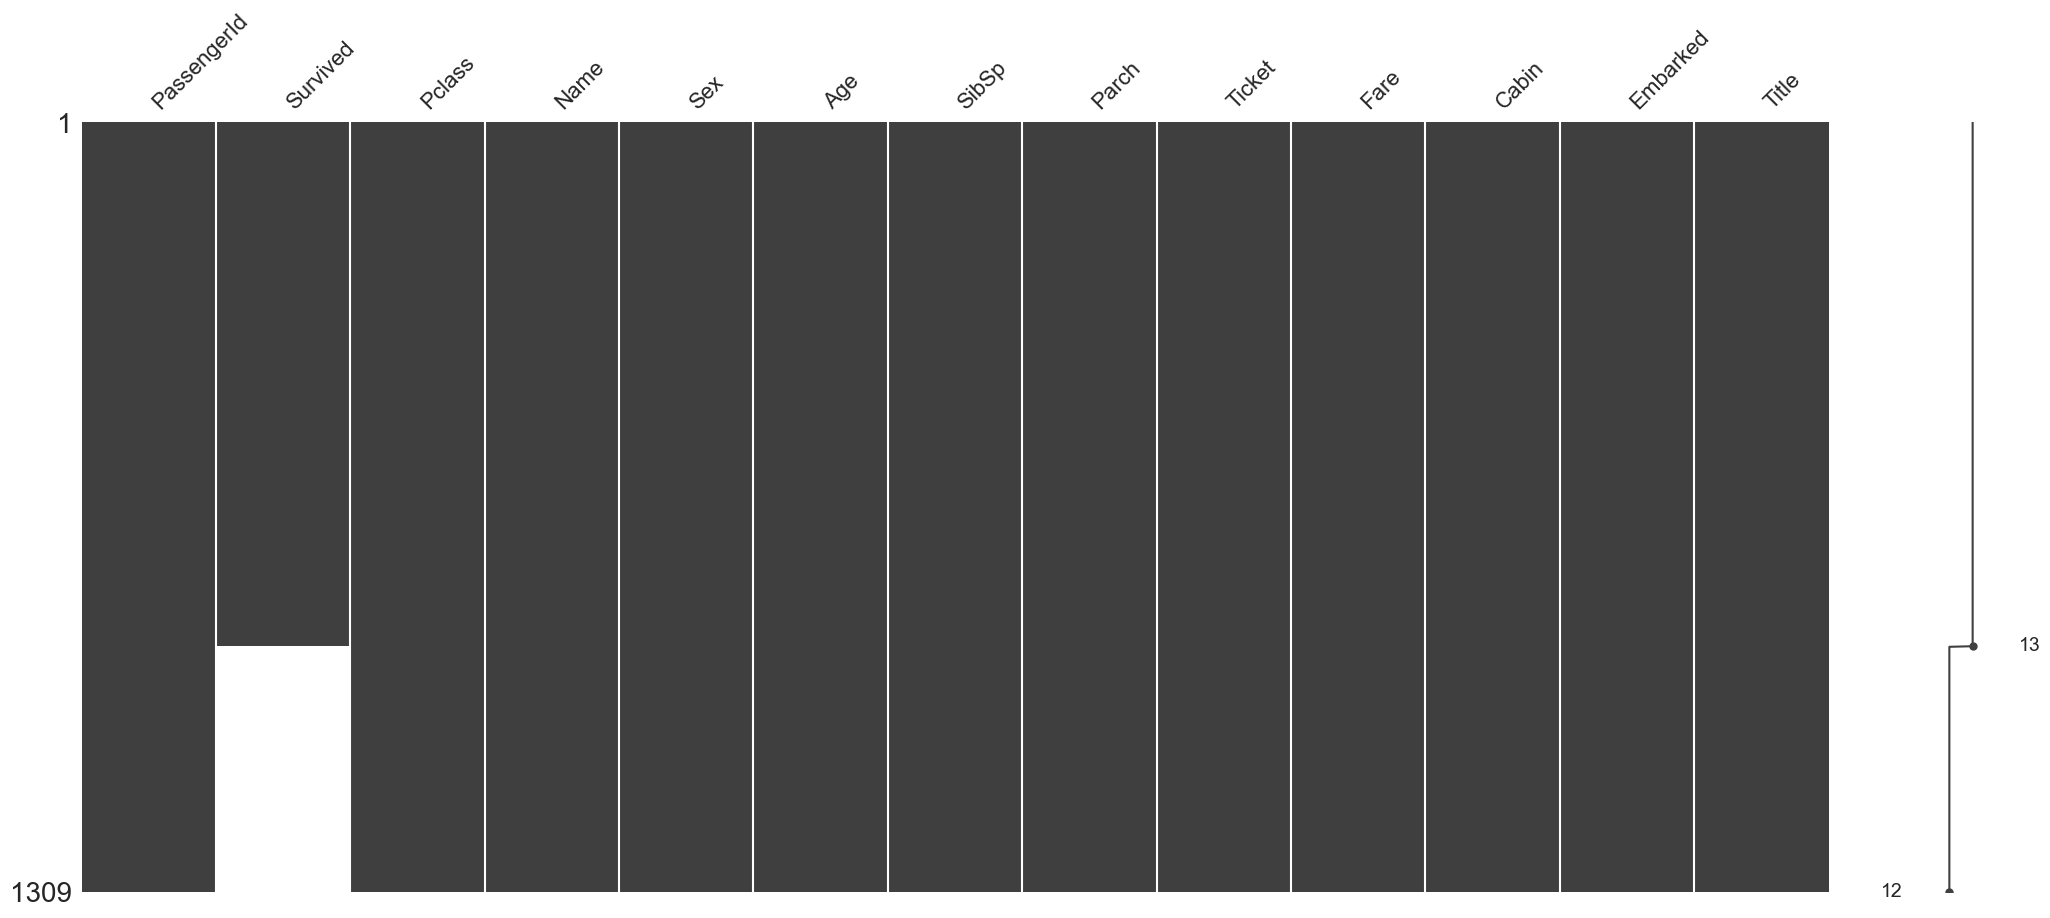

In [40]:
missingno.matrix(df_all)

## Feature Engineering

### 연속형 피처 -> 구간별로 나누기

### Fare

In [41]:
df_all.loc[ df_all['Fare'] <= 20, 'Fare'] = 0
df_all.loc[(df_all['Fare'] > 20) & (df_all['Fare'] <= 40), 'Fare'] = 1
df_all.loc[(df_all['Fare'] > 40) & (df_all['Fare'] <= 60), 'Fare'] = 2
df_all.loc[(df_all['Fare'] > 60) & (df_all['Fare'] <= 80), 'Fare'] = 3
df_all.loc[(df_all['Fare'] > 80) & (df_all['Fare'] <= 100), 'Fare'] = 4
df_all.loc[ df_all['Fare'] > 100, 'Fare'] = 5

### Age

In [42]:
df_all.loc[df_all['Age'] <= 2, 'Age'] = 0
df_all.loc[(df_all['Age'] > 2) & (df_all['Age'] <= 15), 'Age'] = 1
df_all.loc[(df_all['Age'] > 15) & (df_all['Age'] <= 20), 'Age'] = 2
df_all.loc[(df_all['Age'] > 20) & (df_all['Age'] <= 33), 'Age'] = 3
df_all.loc[(df_all['Age'] > 33) & (df_all['Age'] <= 43), 'Age'] = 4
df_all.loc[(df_all['Age'] > 43) & (df_all['Age'] <= 60), 'Age'] = 5
df_all.loc[(df_all['Age'] > 60) & (df_all['Age'] <= 75), 'Age'] = 6
df_all.loc[ df_all['Age'] > 75, 'Age'] = 7

### 범주형 인코딩

### Family-Size

In [43]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

### Family_Size_Group

In [44]:
df_all.loc[df_all['Family_Size'] <= 1, 'Family_Size_Group'] = 'Alone'
df_all.loc[(df_all['Family_Size'] > 1) & (df_all['Family_Size'] <= 4), 'Family_Size_Group'] = 'Small'
df_all.loc[(df_all['Family_Size'] > 4) & (df_all['Family_Size'] <= 6), 'Family_Size_Group'] = 'Medium'
df_all.loc[ df_all['Family_Size'] > 6, 'Family_Size_Group'] = 'Large'

### Ticket_Frequency

In [45]:
def refine_ticket(data):
    tickets = list()
    for index in range(len(data)):
        ticket = data.iloc[index]
        ticket = ticket.replace(' ', '').strip()
        for punctuation in string.punctuation:
            ticket = ticket.replace(punctuation, '')
        tickets.append(ticket)
    return tickets
df_all['Ticket_Refinement'] = refine_ticket(df_all['Ticket'])
df_all['Ticket_Frequency'] = df_all.groupby('Ticket_Refinement')['Ticket_Refinement'].transform('count')

In [46]:
df_all[df_all['Ticket_Frequency'] == 5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family_Size,Family_Size_Group,Ticket_Refinement,Ticket_Frequency
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,0.0,3,1,349909,1.0,X,S,Master,5,Medium,349909,5
24,25,0.0,3,"Palsson, Miss. Torborg Danira",female,1.0,3,1,349909,1.0,X,S,Mz,5,Medium,349909,5
86,87,0.0,3,"Ford, Mr. William Neal",male,2.0,1,3,W./C. 6608,1.0,X,S,Mr,5,Medium,WC6608,5
147,148,0.0,3,"Ford, Miss. Robina Maggie ""Ruby""",female,1.0,2,2,W./C. 6608,1.0,X,S,Mz,5,Medium,WC6608,5
176,177,0.0,3,"Lefebre, Master. Henry Forbes",male,1.0,3,1,4133,1.0,X,S,Master,5,Medium,4133,5
229,230,0.0,3,"Lefebre, Miss. Mathilde",female,3.0,3,1,4133,1.0,X,S,Mz,5,Medium,4133,5
319,320,1.0,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",female,4.0,1,1,16966,5.0,E,C,Mz,3,Small,16966,5
337,338,1.0,1,"Burns, Miss. Elizabeth Margaret",female,4.0,0,0,16966,5.0,E,C,Mz,1,Alone,16966,5
374,375,0.0,3,"Palsson, Miss. Stina Viola",female,1.0,3,1,349909,1.0,X,S,Mz,5,Medium,349909,5
377,378,0.0,1,"Widener, Mr. Harry Elkins",male,3.0,0,2,113503,5.0,C,C,Mr,3,Small,113503,5


### Family_Name
- 이름은 Lefebre(Sur Name),(콤마) Master.(Initial) Henry Forbes(First Name)

In [47]:
def get_surname(data):
    surnames = list()
    for index in range(len(data)):
        name = data.iloc[index].split(',')[0]
        name = name.replace(' ', '').strip()
        for punctuation in string.punctuation:
            name = name.replace(punctuation, '')
        surnames.append(name)
    return surnames
df_all['Family_Name'] = get_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]

### Family_Survival_Rate & Ticket_Survival_Rate

In [48]:
df_train.groupby('Family_Name')['Survived', 'Family_Size'].median()

,Survived,Family_Size
Family_Name,,
Abbing,0.0,1.0
Abbott,0.5,3.0
Abelson,0.5,2.0
Adahl,0.0,1.0
Adams,0.0,1.0
...,...,...
deMulder,1.0,1.0
dePelsmaeker,0.0,1.0
delCarlo,0.0,2.0


In [49]:
df_family_survived_rate = df_train.groupby('Family_Name')['Survived', 'Family_Size'].median()

family_rates = dict()
for family_name in df_family_survived_rate.index:
    if df_family_survived_rate.loc[family_name][1] > 1 and (family_name in df_train['Family_Name'].unique() and family_name in df_test['Family_Name'].unique()):
        family_rates[family_name] = df_family_survived_rate.loc[family_name][0]

family_survival_rate = list()
family_survival_rate_NA = list()
mean_survival_rate = np.mean(df_train['Survived'])

for i in range(len(df_all)):
    if df_all['Family_Name'][i] in family_rates:
        family_survival_rate.append(family_rates[df_all['Family_Name'][i]])
        family_survival_rate_NA.append(1)
    else:
        family_survival_rate.append(mean_survival_rate)
        family_survival_rate_NA.append(0)

df_all['Family_Survival_Rate'] = family_survival_rate
df_all['Family_Survival_Rate_NA'] = family_survival_rate_NA

In [50]:
df_ticket_survived_rate = df_train.groupby('Ticket_Refinement')['Survived', 'Ticket_Frequency'].median()

ticket_rates = dict()
for ticket_name in df_ticket_survived_rate.index:
    if df_ticket_survived_rate.loc[ticket_name][1] > 1 and (ticket_name in df_train['Ticket_Refinement'].unique() and ticket_name in df_test['Ticket_Refinement'].unique()):
        ticket_rates[ticket_name] = df_ticket_survived_rate.loc[ticket_name][0]

ticket_survival_rate = list()
ticket_survival_rate_NA = list()
mean_survival_rate = np.mean(df_train['Survived'])

for i in range(len(df_all)):
    if df_all['Ticket_Refinement'][i] in ticket_rates:
        ticket_survival_rate.append(ticket_rates[df_all['Ticket_Refinement'][i]])
        ticket_survival_rate_NA.append(1)
    else:
        ticket_survival_rate.append(mean_survival_rate)
        ticket_survival_rate_NA.append(0)

df_all['Ticket_Survival_Rate'] = ticket_survival_rate
df_all['Ticket_Survival_Rate_NA'] = ticket_survival_rate_NA

### Survival_Rate

In [51]:
df_all['Total_Survival_Rate'] = (df_all['Ticket_Survival_Rate'] + df_all['Family_Survival_Rate']) / 2
df_all['Total_Survival_Rate_NA'] = (df_all['Ticket_Survival_Rate_NA'] + df_all['Family_Survival_Rate_NA']) / 2
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]

### OneHot Encoding

In [52]:
onehot_cols = ['Pclass', 'Sex', 'Cabin', 'Embarked', 'Title', 'Family_Size_Group']
df_train = pd.get_dummies(df_train, columns=onehot_cols)
df_test = pd.get_dummies(df_test, columns=onehot_cols)

### Model

- - StandardScaler: 기본 스케일로, 평균과 표준편차 사용하여 스케일링
  - MinMaxScaler: 최대/최소값이 1/0이 되도록 스케일링

In [53]:
drop_cols = ['Family_Name', 'Family_Size', 'Survived',
             'Name', 'Parch', 'PassengerId', 'SibSp', 'Ticket',
             'Family_Survival_Rate', 'Ticket_Survival_Rate',
             'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA', 'Ticket_Refinement']

In [54]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

### 모델 파라미터 선택
- GridSearchCV()를 사용한 hyper parameter 값 사용

In [55]:
single_best_model = RandomForestClassifier(
    n_estimators=1500,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=6,
    oob_score=True,
    random_state=1,
    n_jobs=-1,
    verbose=True)

### 새로배우는 부분: OOB Score 및 생존확률 계산

In [56]:
skf = StratifiedKFold(n_splits=5, random_state=5, shuffle=True)
probs = pd.DataFrame(
    np.zeros((len(X_test), 5)),
    columns=['Fold{}'.format(i) for i in range(5)]
)

oob = 0
for fold, indices in enumerate(skf.split(X_train, y_train)):
    train_index, val_index = indices
    single_best_model.fit(X_train[train_index], y_train[train_index])
    oob += single_best_model.oob_score_
    probs['Fold{}'.format(fold)] = single_best_model.predict_proba(X_test)[:, 1] # 각 fold 에서 해당 사람이 Survived 될 확률

print ("OOB Score:", "{:.3f}".format(oob / 5))

probs['avg'] = probs.mean(axis=1) # 해당 사람이 fold 별 Survived 될 확률의 평균 계산
probs['final'] = 0
probs.loc[probs['avg'] > 0.5, 'final'] = 1 # 해당 사람이 fold 별 Survived 될 확률의 평균이 50% 이상일 경우, 최종 생존으로 예측

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    1.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concur

OOB Score: 0.846


In [58]:
submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = probs['final'].tolist()
submission_df.to_csv('submissions_final.csv', header=True, index=False)
submission_df.tail(2)

,PassengerId,Survived
1307,1308,0
1308,1309,1


In [59]:
!kaggle competitions submit -c titanic -f submissions_final.csv -m "Message"

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 27.8kB/s]
100%|##########| 3.18k/3.18k [00:02<00:00, 1.23kB/s]


In [60]:
from sklearn.model_selection import GridSearchCV

n_estimators = [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700]
max_depth = [5, 6, 7, 8, 9, 10]
min_samples_split = [5, 6, 7, 8, 9, 10]
min_samples_leaf = [5, 6, 7, 8, 9, 10]

hyperparams = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

gd=GridSearchCV(
    estimator = RandomForestClassifier(random_state=1),
    param_grid = hyperparams,
    verbose=True,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
0.8473165526332307
{'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1500}
